## Spam Email Detection

### Initialisation

#### Import Libraries

In [90]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import wordcloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rishabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Import Dataset

In [91]:
df = pd.read_csv('emails.csv')
df.columns = ['Content','Label']
df['Label'].replace(to_replace=[1,0],value=['Spam','Not Spam'],inplace=True)
df.sample(5)

,Content,Label
893,Subject: hey aro aro ; ) projecthoneypot @ pr...,Spam
5609,Subject: candidate : howard information vince...,Not Spam
5545,Subject: re : telephone interview with the enr...,Not Spam
2355,Subject: employees that are listed in the rese...,Not Spam
2734,Subject: re : good morning / afternoon thanks...,Not Spam


#### Value Counts


In [92]:
df.value_counts().sum()

5728

### Data Cleaning

#### Missing Value Analysis

In [93]:
df.isnull().sum()

Content    0
Label      0
dtype: int64

#### Duplicate Removal 

In [94]:
df.duplicated().sum()

33

In [95]:
df.drop_duplicates(inplace=True)
df.shape

(5695, 2)

#### Dataset Description

In [96]:
df.describe()

,Content,Label
count,5695,5695
unique,5695,2
top,Subject: naturally irresistible your corporate...,Not Spam
freq,1,4327


#### Shape

In [97]:
df.shape

(5695, 2)

### Exploratory Data Analysis

#### Label Distribution

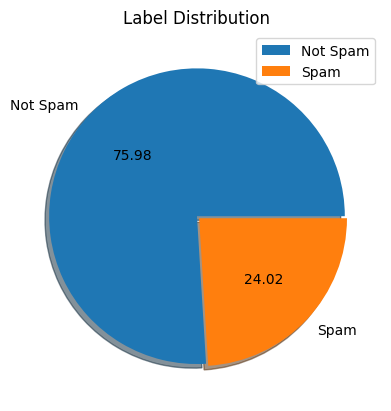

In [98]:
plt.pie(df['Label'].value_counts(),autopct="%0.2f",labels=['Not Spam','Spam'],explode=[0,0.02],shadow=True)
plt.legend(loc='best')
plt.title('Label Distribution')
plt.show()

#### Word Cloud for Content

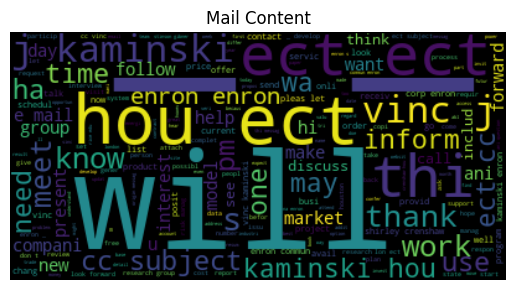

In [112]:
from wordcloud import WordCloud
text = " ".join(x for x in df[df['Label']=='Spam']['Content'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Spam Mail Content')
plt.show()

### Text Preprocessing

#### Remove Subject and Replied Notations

In [100]:
df['Content'] = [str.replace('subject: ','') for str in df['Content']]
df['Content'] = [str.replace('re : ','') for str in df['Content']]
df.sample(10)

,Content,Label
4925,Subject: a colossal and dangerous failure - ce...,Not Spam
2636,Subject: bollerslev seminar excellent . thank...,Not Spam
4788,"Subject: bonds the difference is $ 4 , 391 . ...",Not Spam
646,Subject: you want to submit your website to se...,Spam
4076,Subject: revised 10 cpm color copier informati...,Not Spam
5083,Subject: probation period - matthew williams ...,Not Spam
4045,Subject: chase vince : thanks very much . i w...,Not Spam
3092,Subject: cplex floating license chonawee and ...,Not Spam
1433,"Subject: petrochem desk vasant , it seems we...",Not Spam
2387,Subject: riskbrief - january issue riskbrief ...,Not Spam


#### Porter Stemming

In [101]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_sentence(sentence):
    new=""
    for word in sentence.split(" "):
        new+=stemmer.stem(word.strip(',').strip('!').strip(' '))+" "
    return new

df['Content'] = [stem_sentence(row) for row in df['Content']]

#### Remove Subject and Reply 

In [102]:
df['Content'] = [x.replace("subject: ","") for x in df['Content']]
df['Content'] = [x.replace("re : ","") for x in df['Content']]

### Model Preparation

#### Test-Train Split

In [103]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(df['Content'],df['Label'],test_size=0.3)

#### Vectorization

In [104]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### Model Fitting

In [105]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150)
model.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=150)

#### Prediction and Accuracy Test

In [106]:
from sklearn.metrics import accuracy_score,f1_score,precision_score
Y_predict = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(Y_test,Y_predict)*100,3)}")
print(f"Precision: {round(precision_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")
print(f"F1 Score: {round(f1_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")

Accuracy: 97.894
Precision: 97.583
F1 Score: 98.626


#### Confusion Matrix

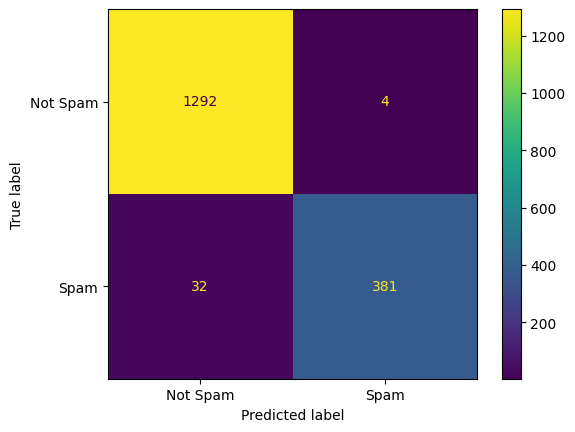

In [107]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test, Y_predict,labels=model.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = model.classes_)
cm_display.plot()
plt.show()

### Model Saving and Storing

#### Model Pickling

In [108]:
import pickle
fm = open('pickles/model_pickle','wb')
pickle.dump(model,fm)

fv = open('pickles/vectorizer_pickle','wb')
pickle.dump(vectorizer,fv)